In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sympy as sp
from sklearn import metrics
import os

In [2]:
plt.rcParams.update({
    'font.size': 12,           # Global font size for all text
    'font.family': 'sans-serif', # Global font family
    'font.sans-serif': ['Arial'],  # Preferred sans-serif font
    'axes.titlesize': 16,      # Font size for titles
    'axes.labelsize': 14,      # Font size for axis labels
    'xtick.labelsize': 12,     # Font size for x-axis tick labels
    'ytick.labelsize': 12,     # Font size for y-axis tick labels
    'legend.fontsize': 11,     # Font size for legends
    'figure.titlesize': 16,    # Font size for figure title
})

In [4]:
dso_path = os.path.join(os.getcwd(), 'result_dso')
data_path = os.path.join(os.getcwd(), 'data', 'processed_data')
#data_name = 'combined_data_add_features_3_filtered_normalized.csv'
#data = pd.read_csv(os.path.join(data_path, data_name))
files = os.listdir(dso_path)
print(files)

['_home_ruilwang_ML-uv-theory_data_processed_data_combined_data_add_features_3_filtered_normalized_2024-10-21-181723', 'combined_data_add_features_3_filtered_normalized_10-22_1456', 'figures', 'combined_data_add_features_3_filtered_normalized_10-22_2255', 'combined_data_add_features_3_filtered_normalized_10-22_0249', 'combined_data_add_features_3_filtered_normalized_10-22_1958', 'combined_data_add_features_3_filtered_normalized_10-21_2127']


In [5]:
def read_dso_result(file):
    name = file[:-11] + '_0'
    
    # Construct file paths safely using os.path.join
    hof_path = os.path.join(dso_path, file, f'dso__home_ruilwang_ML-uv-theory_data_processed_data_{name}_hof.csv')
    pf_path = os.path.join(dso_path, file, f'dso__home_ruilwang_ML-uv-theory_data_processed_data_{name}_pf.csv')
    summary_path = os.path.join(dso_path, file, f'dso__home_ruilwang_ML-uv-theory_data_processed_data_{name}.csv')
    
    # Check if all files exist before reading
    if not (os.path.exists(hof_path) and os.path.exists(pf_path) and os.path.exists(summary_path)):
        raise FileNotFoundError(f"One or more files are missing: {hof_path}, {pf_path}, {summary_path}")
    
    # Read the CSV files
    hof = pd.read_csv(hof_path)
    pf = pd.read_csv(pf_path)
    summary = pd.read_csv(summary_path)
    print(f"Read {file} successfully")
    return hof, pf, summary

def y_calculation(hof_data, origin_data):
    best_equation = hof_data.loc[hof_data['r'].idxmax(), 'expression']
    equation = sp.sympify(best_equation)
    # Dynamically create symbolic variables based on the number of columns in the data
    num_vars = origin_data.shape[1]-1  # Get the number of input columns (x1, x2, ..., xn)
    symbols = sp.symbols(f'x1:{num_vars + 1}')  # Create a tuple of symbols (x1, x2, ..., xn)
    equation_func = sp.lambdify(symbols, equation, "numpy")
    y = equation_func(*[origin_data.iloc[:, i] for i in range(num_vars)])
    return y, equation

def plot_pareto(pf):
    plt.figure(figsize=(14, 5))
    plt.suptitle('Pareto Front', fontsize=16)
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=pf, x='complexity', y='r', s=100, color ='#92A8D1')
    plt.xlabel('Complexity')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=pf, x='complexity', y='nmse_test', s=100, color = '#DD4124')
    plt.xlabel('Complexity')
    plt.ylabel('NMSE')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
def plot_hof(hof):
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(len(hof)), hof['r'],color = '#92A8D1')
    plt.ylabel('reward')
    plt.xlabel('hof reward distribution')

    plt.subplot(2, 2, 2)
    plt.plot(np.arange(len(hof)), hof['nmse_test'], color = '#DD4124')
    plt.ylabel('nmse_test')
    plt.xlabel('hof nmse_test distribution')

    plt.subplot(2, 2, 3)
    # box plot of r
    sns.boxplot(hof['r'], orient='h', color = '#92A8D1')
    plt.subplot(2, 2, 4)
    # box plot of nmse_test
    sns.boxplot(hof['nmse_test'], orient='h', color = '#DD4124')
    plt.show()

def error_percentage(y, y_pred):
    percentage = np.abs((y - y_pred) / y) * 100
    # delete inf values in percentage
    percentage = percentage[percentage != np.inf]
    error = np.mean(percentage)
    print("Mean Absolute Percentage Error: ", error)
    return error

def regression_plot(y_origin, y_pred):
    plt.scatter(y_origin, y_pred, color='#955251')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    r2 = metrics.r2_score(y_origin, y_pred)
    MAPE = error_percentage(y_origin, y_pred)
    plt.text(0.1, 0.9, f'$R^2$ = {r2:.2f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'MAPE = {MAPE:.2f}%', transform=plt.gca().transAxes)
    plt.plot(y_origin, y_origin, color='slategray', linestyle='--')
    
def plot_predict(hof, data):
    y, equation = y_calculation(hof, data)
    plt.figure(figsize=(14, 16))
    plt.subplot(4, 3, 1)
    regression_plot(data['delta_phi'], y)

    plt.subplot(4, 3, 2)
    ymax = max(y.max(), data['delta_phi'].max()) + 0.05
    ymin = min(y.min(), data['delta_phi'].min()) - 0.05
    scatter = plt.scatter(data['density'], data['delta_phi'], c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('$\\Delta \\phi$')

    plt.subplot(4, 3, 3)
    scatter = plt.scatter(data['density'], y, c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    color_bar.set_label('Temperature')
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('Predicted Value')

    unique_mw = data['Molecular_Weight'].unique()
    for i in range(1, min(4, len(unique_mw) + 1)):  # Loop through molecular weights
        data_part = data[data['Molecular_Weight'] == unique_mw[i-1]]
        y_part, equation = y_calculation(hof, data_part)

        plt.subplot(4, 3, i * 3 + 1)
        regression_plot(data_part['delta_phi'], y_part)

        plt.subplot(4, 3, i * 3 + 2)
        ymax = max(y_part.max(), data_part['delta_phi'].max()) + 0.05
        ymin = min(y_part.min(), data_part['delta_phi'].min()) - 0.05
        scatter = plt.scatter(data_part['density'], data_part['delta_phi'], c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('$\\Delta \\phi$')

        plt.subplot(4, 3, i * 3 + 3)
        scatter = plt.scatter(data_part['density'], y_part, c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        color_bar.set_label('Temperature')
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()

In [16]:
hof, pf, summary = read_dso_result(files[3])

Read combined_data_add_features_3_filtered_normalized_10-22_2255 successfully


In [19]:
y, equation = y_calculation(hof, data)
equation

x2*(16.153523447276328*x3 + 16.153523447276328*exp(exp(x1 + 1.085204069193592*x2 - 0.915132539023793*x3 - 0.915132539023793*x4)) - 16.153523447276328*tanh(x2 + exp(sin(sin(x2)))) - 0.90634288575875126)*tanh(sin(cos(exp((x5 - 4.198558547266957)*cos(cos(tanh(cos(x3)))) + 0.9594716659477326*exp(tanh(x1))) + 2.78838185690727*sin(tanh(x5)) + 1.7703568524017081) + 2.1773809449022186) - 1.0058839120236855)

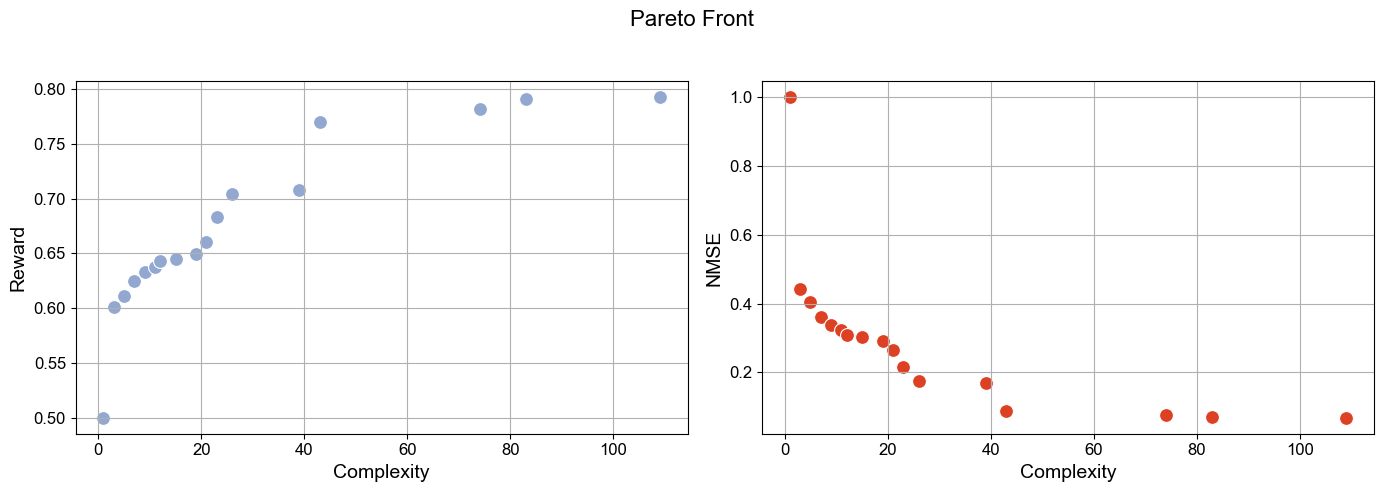

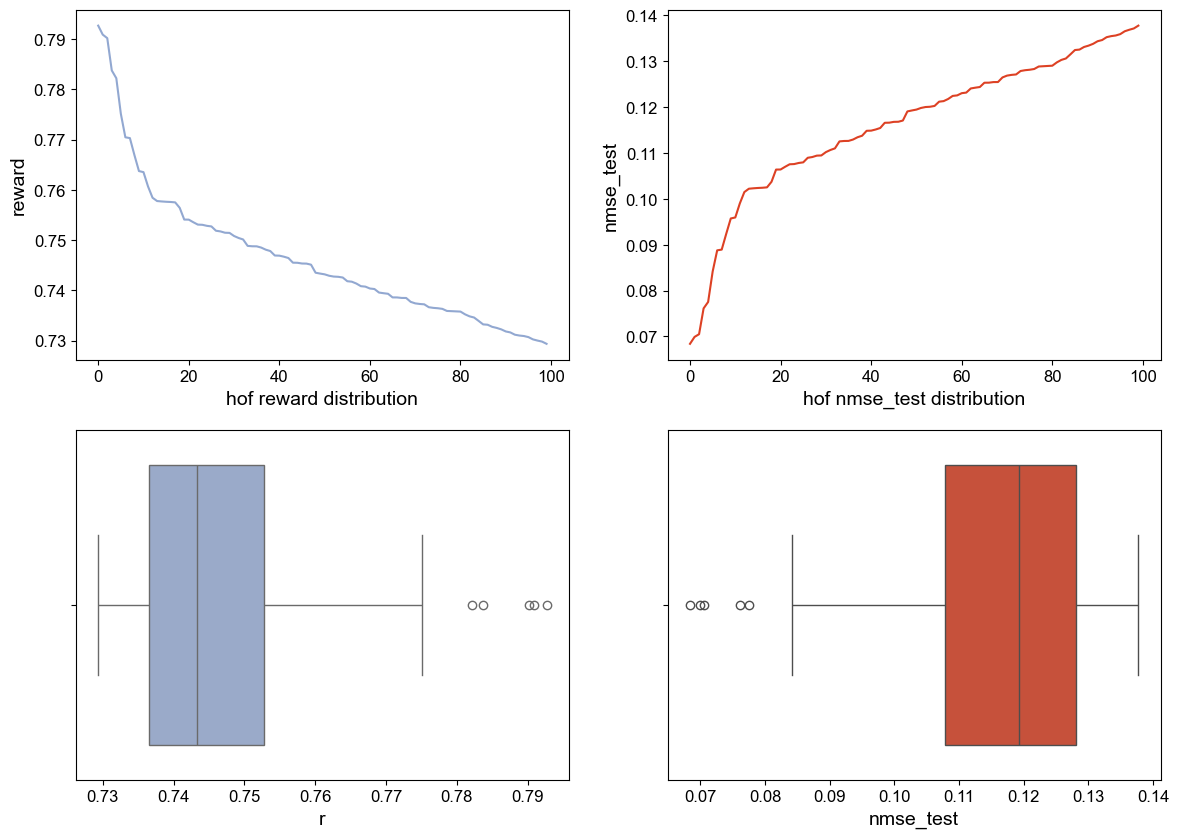

In [17]:
plot_pareto(pf)
plot_hof(hof)

Mean Absolute Percentage Error:  23.68338434233386
Mean Absolute Percentage Error:  187.3795449085361
Mean Absolute Percentage Error:  14.88396845357086
Mean Absolute Percentage Error:  22.41259931627474


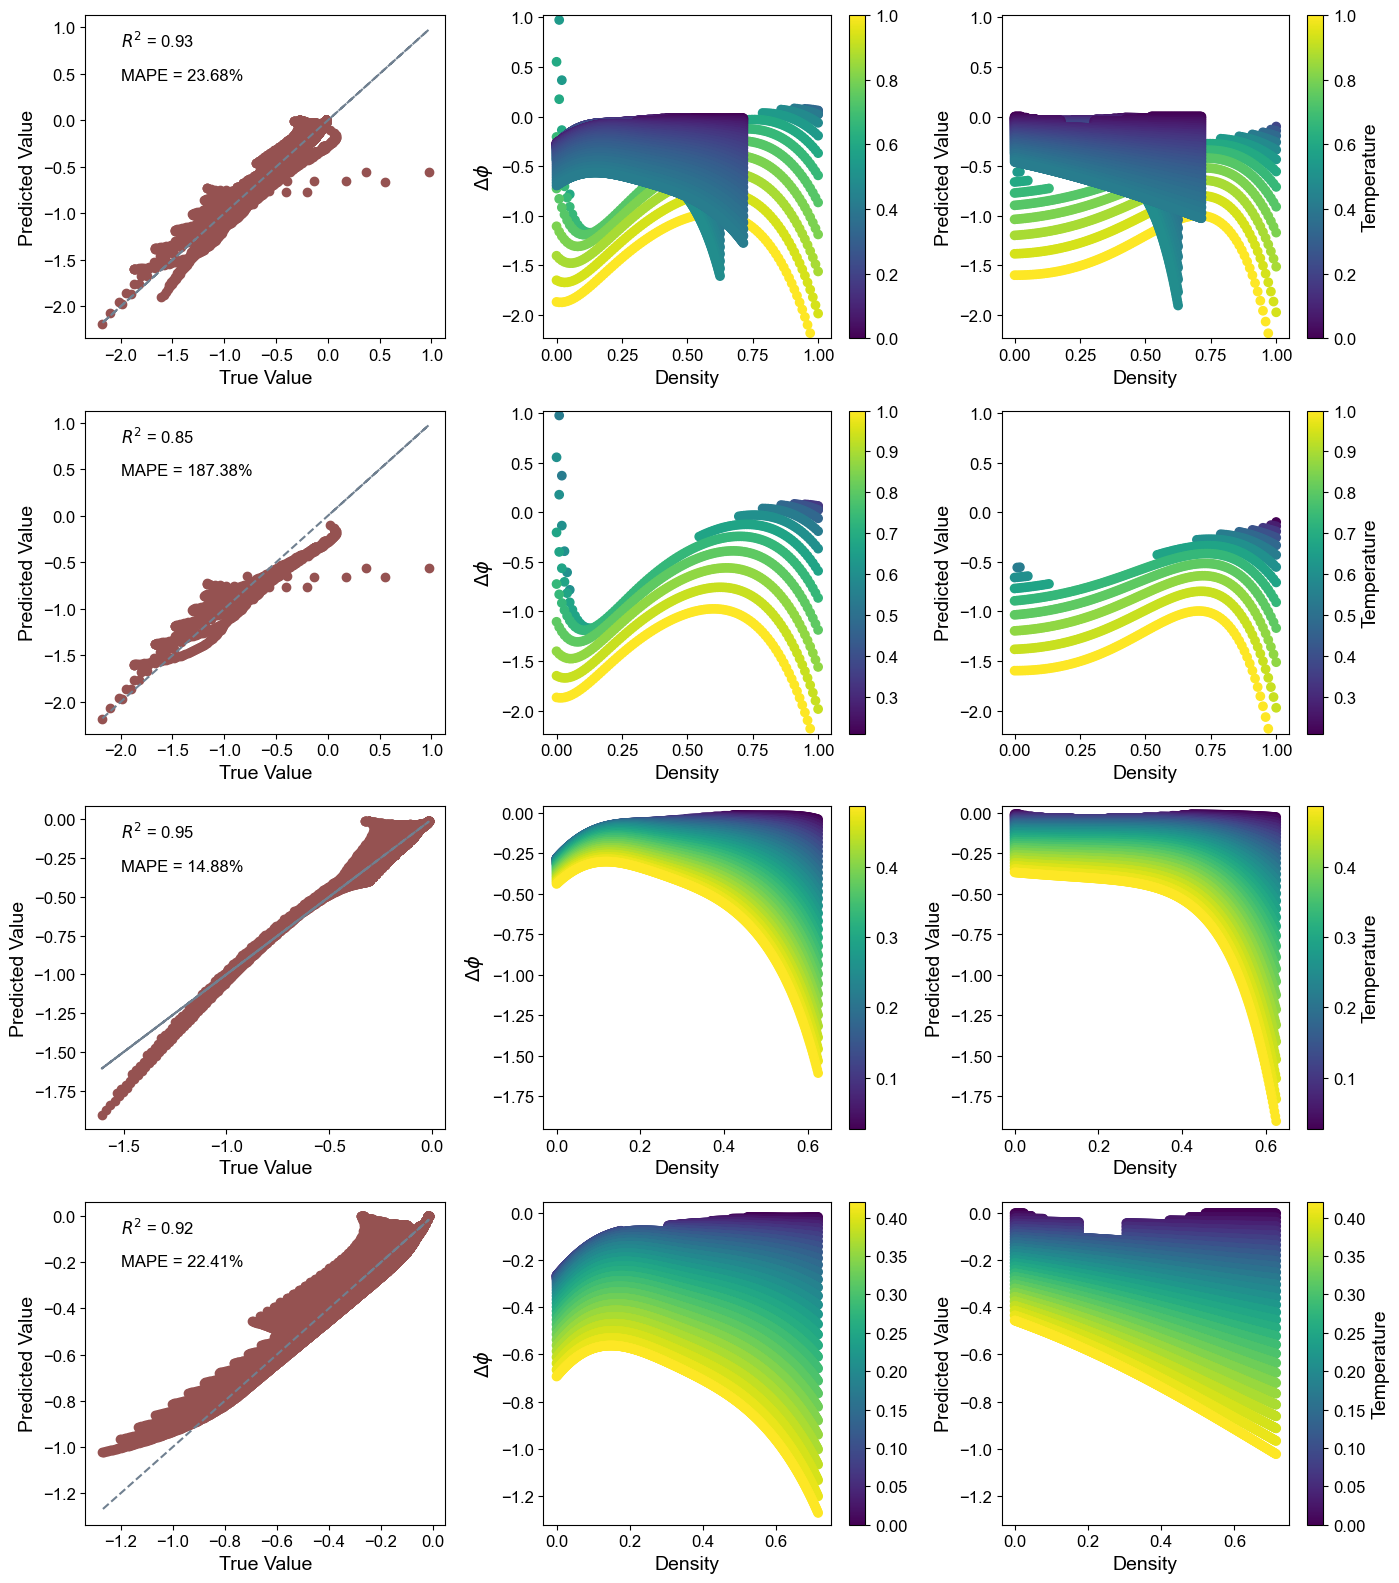

In [18]:
plot_predict(hof, data)
